# Making a DQN Using OpenAI Gym's Cartpole Environment V1

In this notebook I will be going through the process of making and training a DQN, tuning its hyperparameters and comparing it to an equivalent DDQN. The aim is to create an agent that can survive for more than 100 frames over 50 episodes. We will limit the entire process to 300 episodes (i.e. the agent must explore and exploit within that time). The aim here is also for simplicity - the networks made do not need to be overly complex to satisfy the minimum requirements.

See [here](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) for the documentation of the environment.

Definitions:
- Episode: a set of frames played by the agent from a random initialisation to failure (either the pole topples over or the cart reaches the end of the screen).
- Frame: a 0.02s snapshot of the screen that the agent can act on.
- Score: the total number of frames that an agent survives during an episode.

First we import the relevant packages.

In [2]:
from utils import *
from tqdm import tqdm
import torch
import torch.optim as optim
import pickle
import numpy as np
import json
import gym
import matplotlib.pyplot as plt

Next we define the training process. We first make the environment and initialise it with a network with randomised weights.
Then, the agent will work as follows:
- The agent selects an action using its policy network.
- It then saves the action and the outcome to its memory.
- It takes a random sample from its memory, and uses it to compute the loss against the Bellman targets. Here how the losses are calculated differ for a DQN vs DDQN (see below).
- It performs an update in order to minimise that loss.

The training process is wrapped in a run_experiment function, that allows us to set the hyperparameters that are relevant to the task, and it returns the trained agent and the score that it achieves, averaged over a pre-defined number of runs.


In [3]:
def run_experiment(neurons_per_layer, num_runs, epsilon_0, epsilon_decay_rate, learning_rate, optimiser,
                   replay_buffer_size, batch_size, target_update_frequency, no_episodes, ddqn=False):
    """Run the environment with the given parameters.

    Args:
        num_layers (int) : number of layers in the DQN.
        neurons_per_layer (list) : list of number of neurons per layer of the DQN
        num_runs (int) : the number of runs to complete.
        epsilon (float) : the exploration parameter of the agent.
        epsilon_decay_rate (float) : the decay rate of epsilon per episode.
        learning_rate (float) : the learning rate of the agent.
        optimiser (torch.Any) : the gradient descent optimiser to use.
        replay_buffer_size (int) : the size of the memory of the agent.
        batch_size (int) : the number of samples per episode that the agent learns from.
        target_update_frequency (int) : the frequency with which the target is updated.
        ddqn (bool) : whether the agent learns from a DQN or DDQN.

    Returns:
        runs_results (list) : list of results per run.
    """
    runs_results = []

    env = gym.make('CartPole-v1')
    for run in range(num_runs):
        # print(f"Starting run {run+1} of {num_runs}")
        policy_net = DQN(neurons_per_layer)
        target_net = DQN(neurons_per_layer)
        update_target(target_net, policy_net)
        target_net.eval()  # Tells dropout what mode to go in.
        epsilon = epsilon_0
        optimizer = optimiser(policy_net.parameters(), lr=learning_rate)
        memory = ReplayBuffer(replay_buffer_size)

        episode_durations = []

        for i_episode in range(no_episodes):
            # if (i_episode+1) % 50 == 0:
            #     print("episode ", i_episode+1, "/", 300)
            observation, info = env.reset()
            state = torch.tensor(observation).float()

            done = False
            terminated = False
            t = 0
            epsilon -= epsilon_decay_rate * epsilon
            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(epsilon, policy_net, state)

                observation, reward, done, terminated, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < batch_size:
                    transitions = memory.sample(batch_size=batch_size)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = \
                        (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch,
                                    reward_batch, nextstate_batch, dones, ddqn=ddqn)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()

                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1

            # Update the target network, copying all weights and biases in DQN
            if i_episode % target_update_frequency == 0:
                update_target(target_net, policy_net)
        runs_results.append(episode_durations)

    # print('Complete')
    return runs_results, policy_net

# Tuning the Model

Before running a potentially quite long grid search to find the best hyperparameters of the model, it might be best to think about the problem at hand.

The cart pole environment is frictionless, and there are four inputs - pole angle, angular velocity (both measured clockwise), cart position and cart speed (both with right as positive). We want the agent to spit out 2 outputs corresponding to the Q value for action 0 (push to the left) and the Q value for action 1 (push to the right). So the number of inputs to the network will be 4, and the outputs will be 2. I've also tried reducing the dimensions of the problem by removing the cart velocity from the equation, however this produces some erroneous results (see later for why cart speed is important).

The fact the environment is frictionless also means that the physics that the agent is trying to model is not very complex. Therefore a network with maximum of 3 hidden layers should suffice, and these layers need not have a large number of neurons within them. We want the agent to explore a lot at first, but we want to rapidly decay that exploration as the minimum requirements for succeeding at the problem (score of 100) are small, so exploiting quickly will reduce the training and overall run time (my laptop is grateful).


## What effect does the number of hidden layers have on learning?

Here we gain an intuitive understanding, keeping everything else constant. What we see in the graphs below is that having 1 hidden layer performs similarly to having 2 or three. Going with the philosophy that less is more in this case (to avoid the overfitting, where the agent learns specific actions for specific states rather than overall trends), we will stick with 1 hidden layer going forward. When doing the final grid search, we will allow the grid search to find the right answer for itself.

Before running our experiment we save an initial set of parameters.

In [20]:
neurons = [4, 16, 16, 2]
epsilon = 1
epsilon_decay = 0.01
learning_rate = 0.001
replay_buff = 5000
batch_size = 256

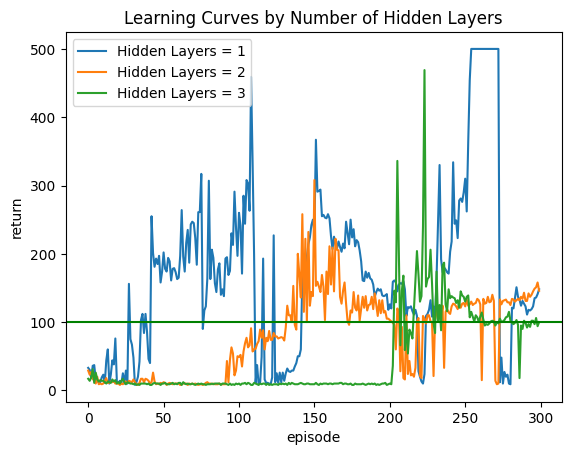

In [14]:
def layers_experiment(epsilon_0, epsilon_decay_rate, learning_rate, replay_buffer_size, batch_size):
    """Test the number of layers in a network."""
    neurons_to_try = [[4, 16, 16, 2], [4, 16, 16, 16, 2], [4, 16, 16, 16, 16, 2]]
    mean_rewards = []
    no_episodes = 300
    for neurons in neurons_to_try:
        runs_results, trained_net = run_experiment(neurons_per_layer=neurons, 
                                                   epsilon_0=epsilon_0, 
                                                   epsilon_decay_rate=epsilon_decay_rate, 
                                                   learning_rate=learning_rate, num_runs=1, 
                                                   optimiser=optim.Adam, 
                                                   replay_buffer_size=replay_buffer_size, 
                                                   batch_size=batch_size, 
                                                   target_update_frequency=10, 
                                                   no_episodes=no_episodes, ddqn=False)
        results = torch.tensor(runs_results)
        means = results.float().mean(0)
        mean_rewards.append(means)
    labels = ['Hidden Layers = 1', 'Hidden Layers = 2', 'Hidden Layers = 3']
    for i in range(len(mean_rewards)):
            plt.plot(torch.arange(no_episodes), mean_rewards[i], label=labels[i])
    plt.axhline(y=100, color='g', linestyle='-')
    plt.ylabel("return")
    plt.xlabel("episode")
    figname = 'Learning Curves by Number of Hidden Layers'
    plt.legend()
    plt.title(figname)
    plt.show()

layers_experiment(epsilon_0=epsilon, epsilon_decay_rate=epsilon_decay, learning_rate=learning_rate, replay_buffer_size=replay_buff, batch_size=batch_size)

There are a few things to note about these lines:
- They are very noisy, as the experiment was only run once. But running it multiple times will aggregate the noise.
- Using our MVP mentality, one hidden layer seems like it will be sufficient for us to break the 100-point barrier.

## What about neurons per hidden layer?

We can again test this quite easily. We see that there is a clear upshift in performance with 16 neurons vs 8, but increasing that number further leads to no huge gains in performance over 300 episodes.

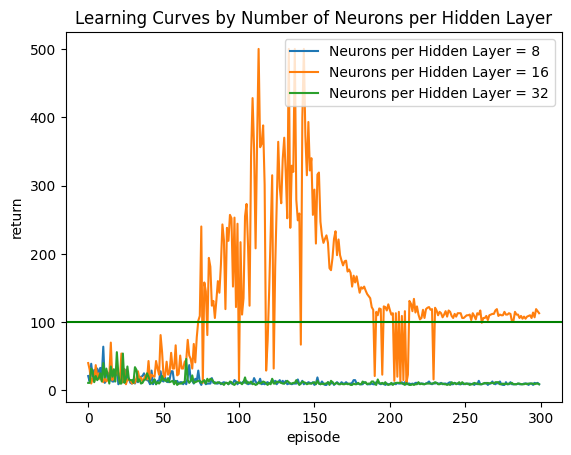

In [23]:
def neurons_per_layer_experiment(epsilon_0, epsilon_decay_rate, learning_rate, replay_buffer_size, batch_size):
    """Test the number of neurons per layer in the network."""
    neurons_to_try = [[4, 8, 8, 2], [4, 16, 16, 2], [4, 32, 32, 2]]
    mean_rewards = []
    no_episodes = 300
    for neurons in neurons_to_try:
        runs_results, trained_net = run_experiment(neurons_per_layer=neurons, 
                                                   epsilon_0=epsilon_0, 
                                                   epsilon_decay_rate=epsilon_decay_rate, 
                                                   learning_rate=learning_rate, num_runs=1, 
                                                   optimiser=optim.Adam, 
                                                   replay_buffer_size=replay_buffer_size, 
                                                   batch_size=batch_size, 
                                                   target_update_frequency=10, 
                                                   no_episodes=no_episodes, ddqn=False)
        results = torch.tensor(runs_results)
        means = results.float().mean(0)
        mean_rewards.append(means)
    labels = ['Neurons per Hidden Layer = 8', 'Neurons per Hidden Layer = 16', 'Neurons per Hidden Layer = 32']
    for i in range(len(mean_rewards)):
            plt.plot(torch.arange(no_episodes), mean_rewards[i], label=labels[i])
    plt.axhline(y=100, color='g', linestyle='-')
    plt.ylabel("return")
    plt.xlabel("episode")
    figname = 'Learning Curves by Number of Neurons per Hidden Layer'
    plt.legend()
    plt.title(figname)
    plt.show()

neurons_per_layer_experiment(epsilon_0=epsilon, epsilon_decay_rate=epsilon_decay, learning_rate=learning_rate, replay_buffer_size=replay_buff, batch_size=batch_size)

Here we see good performance from 16 neurons per layer. No learning took place for the other configurations - that's not to say they were bad, they just happened to have a run of not learning anything due to the random initialisation. However, 16 neurons beats our target score so we will stick with this.

We can repeat the above for our other hyperparameters to gain a better understanding of what effect these have. For the sake of space, I will omit these from the notebook.

# Grid Search

The following three (quite ugly, brute force) functions are to run a quick grid search over a (now much more informed) search space. The agents are ranked based on two parameters:

- First, if in the last 50 episodes the agent achieves an average score of over 100. If the agents do not then they are discarded.
- They are then ranked on their total score over the full 300 episodes.

In [18]:
def grid_search(layers_to_test, neurons_per_layer, epsilons, 
                epsilon_decays, learning_rates, num_runs, 
                optimisers_to_test, replay_buffer_sizes_to_test, 
                batch_sizes_to_test, target_update_frequency, 
                no_episodes):
    return_threshold = 100
    no_of_episodes_for_threshold = 50
    passed_networks = {}
    counter = 1
    all_results = {}
    for layers in layers_to_test:
        for neurons in neurons_per_layer:
            neuron_layers = create_uniform_neurons_per_layer_list(no_of_input_neurons=4,
                                                                  no_of_output_neurons=2, 
                                                                  no_of_layers=layers,
                                                                  no_of_neurons_per_hidden_layer=neurons)
            for epsilon in epsilons:
                for epsilon_decay in epsilon_decays:
                    for learning_rate in learning_rates:
                        for optimiser in optimisers_to_test:
                            for replay_buffer_size in replay_buffer_sizes_to_test:
                                for batch_size in batch_sizes_to_test:
                                    for freq in target_update_frequency:
                                        runs_results, policy_net = run_experiment(neurons_per_layer=neuron_layers, 
                                                                                  epsilon_0=epsilon, 
                                                                                  epsilon_decay_rate=epsilon_decay,
                                                                                  learning_rate=learning_rate, 
                                                                                  optimiser=optimiser,
                                                                                  replay_buffer_size=int(replay_buffer_size),
                                                                                  batch_size=batch_size, num_runs=num_runs, 
                                                                                  target_update_frequency=freq, no_episodes=no_episodes)
                                        name = f"epsilon={epsilon}edecay={epsilon_decay}lr={learning_rate}replaysize=" \
                                               f"{replay_buffer_size}batchsize={batch_size}freq={freq}neurons={neuron_layers}"
                                        all_results[name] = runs_results
                                        results = torch.tensor(runs_results, dtype=torch.float)
                                        means = results.float().mean(0)
                                        last_50_avg = (sum(means[-no_of_episodes_for_threshold:])/no_of_episodes_for_threshold).item()
                                        stds = results.float().std(0)
                                        passed = 'no_pass'
                                        if last_50_avg > return_threshold:
                                            passed = 'pass'
                                            passed_networks[str((means.mean(0).item(), stds.mean(0).item()))] \
                                                = {'layers': layers, 'neurons': neuron_layers, 'epsilon': epsilon,
                                                   'epsilon_decay': epsilon_decay, 'learning_rate': learning_rate,
                                                   'optimiser': str(optimiser), 'replay_buffer_size': replay_buffer_size,
                                                   'batch_size': batch_size}
                                        with open(f'networks/{name+passed}', 'wb') as file:
                                            pickle.dump(policy_net, file)
                                        counter += 1
    return passed_networks, all_results

def run_grid_search(folder):
    """Perform a grid search (not used in final report)."""
    layers_to_test = [1, 2]
    neurons_to_test = [8, 12, 16, 32]
    epsilons = [1, 0.7, 0.8, 0.9]
    epsilon_decays = [0.01, 0.1, 0.5]
    learning_rates = [0.001]
    target_update_freq = [5]
    num_runs = 1
    optimisers_to_test = [optim.Adam]
    replay_buffer_sizes = [10000]
    batch_sizes_to_test = [256]
    no_episodes = 300
    passed_networks, all_results = grid_search(layers_to_test, neurons_to_test,
                                               epsilons, epsilon_decays, learning_rates, 
                                               num_runs, optimisers_to_test, 
                                               replay_buffer_sizes, batch_sizes_to_test, 
                                               target_update_freq, no_episodes=no_episodes)
    with open(f'{folder}/best_networks', 'w') as file:
        json.dump(passed_networks, file)
    with open(f'{folder}/all_runs', 'w') as file:
        json.dump(all_results, file)
    return passed_networks

def get_best_network(passed_networks):
    """Get the best network from a dict of networks."""
    scores = []
    for score in passed_networks:
        scores.append(float(score.split(',')[0].split('(')[1]))
    best_score = max(scores)
    key = f'({best_score}, nan)'
    return passed_networks[key]

# Exploration vs Exploitation

This is one key question in this project - how do we balance exploring vs exploiting the agent's policy?

Exploration is controlled by two main factors in this case, the initial exploration parameter $\epsilon$ and the $\epsilon$-decay rate. These work in tandem with the memory and batch size. Initially, we would like the agent to explore as much as possible whilst it is creating a memory of episodes from which to learn from. The high memory size allows the agent to do this, and the high epsilon allows the different state action pairs to be as varied as possible. This is so that it samples as many state-action pairs as possible. Then, once there is a large enough memory from which to sample effectively we would like the agent to start exploiting its optimal policy more closely, whilst still exploring. With time we would like the exploration to drop in order to exploit the policy more.

The following function investigates the initial epsilon and decay rate. Order of magnitude $\epsilon$ should be around 1 with a decay rate of 1-5%.

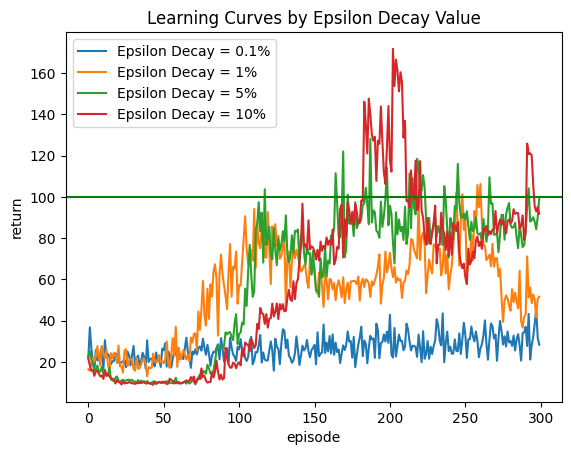

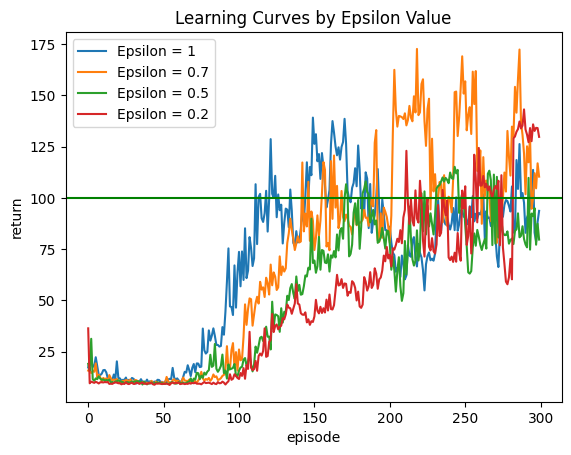

In [8]:
def epsilon_and_epsilon_decay(neurons_per_layer, epsilon_0, epsilon_decay_rate, learning_rate, replay_buffer_size, batch_size):
    """Test the epsilon_0 and epsilon decay rates."""
    no_episodes = 300
    epsilons_decays = [0.001, 0.01, 0.05, 0.1]
    mean_rewards = []
    for epsilon_decay in epsilons_decays:
        no_episodes = 300
        runs_results, trained_net = run_experiment(neurons_per_layer=neurons_per_layer, epsilon_0=epsilon_0, epsilon_decay_rate=epsilon_decay, learning_rate=learning_rate, num_runs=10, optimiser=optim.Adam, replay_buffer_size=replay_buffer_size, batch_size=batch_size, target_update_frequency=10, no_episodes=no_episodes, ddqn=False)
        results = torch.tensor(runs_results)
        means = results.float().mean(0)
        mean_rewards.append(means)
    labels = ['Epsilon Decay = 0.1%', 'Epsilon Decay = 1%', 'Epsilon Decay = 5%', 'Epsilon Decay = 10%']
    for i in range(len(mean_rewards)):
            plt.plot(torch.arange(no_episodes), mean_rewards[i], label=labels[i])
    plt.axhline(y=100, color='g', linestyle='-')
    plt.ylabel("return")
    plt.xlabel("episode")
    figname = 'Learning Curves by Epsilon Decay Value'
    plt.legend()
    plt.title(figname)
    plt.show()

    no_episodes = 300
    epsilons = [1, 0.7, 0.5, 0.2]
    mean_rewards = []
    for epsilon in epsilons:
        no_episodes = 300
        runs_results, trained_net = run_experiment(neurons_per_layer=neurons_per_layer, epsilon_0=epsilon, epsilon_decay_rate=epsilon_decay_rate, learning_rate=learning_rate, num_runs=10, optimiser=optim.Adam, replay_buffer_size=replay_buffer_size, batch_size=batch_size, target_update_frequency=10, no_episodes=no_episodes, ddqn=False)
        results = torch.tensor(runs_results)
        means = results.float().mean(0)
        mean_rewards.append(means)
    labels = ['Epsilon = 1', 'Epsilon = 0.7', 'Epsilon = 0.5', 'Epsilon = 0.2']
    for i in range(len(mean_rewards)):
            plt.plot(torch.arange(no_episodes), mean_rewards[i], label=labels[i])
    plt.axhline(y=100, color='g', linestyle='-')
    plt.ylabel("return")
    plt.xlabel("episode")
    figname = 'Learning Curves by Epsilon Value'
    plt.legend()
    plt.title(figname)
    plt.show()

epsilon_and_epsilon_decay(neurons_per_layer=neurons, epsilon_0=epsilon, epsilon_decay_rate=epsilon_decay, learning_rate=learning_rate, replay_buffer_size=replay_buff, batch_size=batch_size)


# Final Agent Learning Curve

After all this let's run our agent with the following hyperparameters and see what comes out of it.

- Number of hidden layers: 1
- Number of neurons in the hidden layer: 16
- $\epsilon_0$: 1
- $\epsilon$ decay rate: 0.05
- Learning rate: 0.001
- Replay buffer size: 5000
- Batch size: 256

Even with this very simple network - we have passed the benchmark!

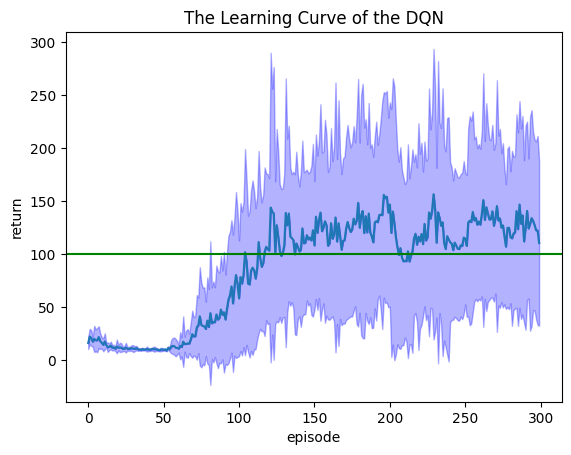

In [9]:
def final_learning_rate(neurons_per_layer, epsilon_0, epsilon_decay_rate, learning_rate, replay_buffer_size, batch_size):
    """Create an averaged learning curve for an agent."""
    no_episodes = 300
    runs_results, trained_net = run_experiment(neurons_per_layer=neurons_per_layer, epsilon_0=epsilon_0, epsilon_decay_rate=epsilon_decay_rate, learning_rate=learning_rate, num_runs=10, optimiser=optim.Adam, replay_buffer_size=replay_buffer_size, batch_size=batch_size, target_update_frequency=10, no_episodes=no_episodes, ddqn=False)
    results = torch.tensor(runs_results)
    means = results.float().mean(0)
    stds = results.float().std(0)

    plt.plot(torch.arange(no_episodes), means)
    plt.axhline(y=100, color='g', linestyle='-')
    plt.ylabel("return")
    plt.xlabel("episode")
    plt.fill_between(np.arange(no_episodes), means, means+stds, alpha=0.3, color='b')
    plt.fill_between(np.arange(no_episodes), means, means-stds, alpha=0.3, color='b')
    figname = 'The Learning Curve of the DQN'
    plt.title(figname)
    plt.show()
    return means, stds, trained_net

means, stds, dqn_net = final_learning_rate(neurons_per_layer=neurons, epsilon_0=epsilon, epsilon_decay_rate=epsilon_decay, learning_rate=learning_rate, replay_buffer_size=replay_buff, batch_size=batch_size)

# Visualising the Policy and Q Values

We have a 4-D space we want to visualise, which is impossible. Therefore we will look at the agent's policy in slices - keeping the cart velocity constant and position equal to zero. As we increase velocity, the yellow action (push cart right) gets more share of the graph. This is due to inertia and angular momentum - applying an impulse to something that's already moving destabilises it more than something that is not.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


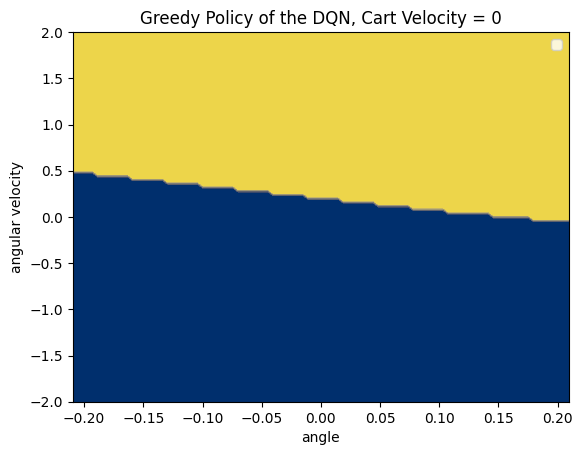

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


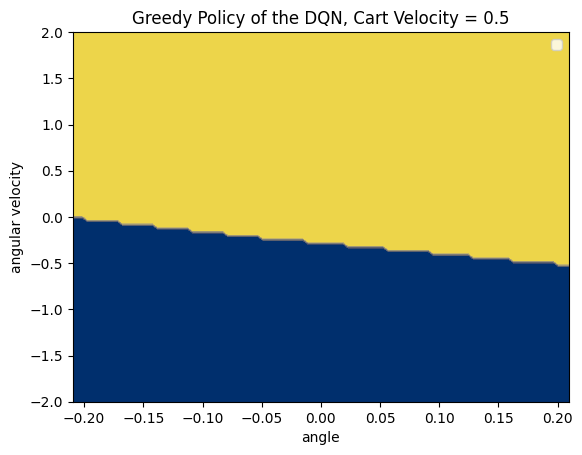

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


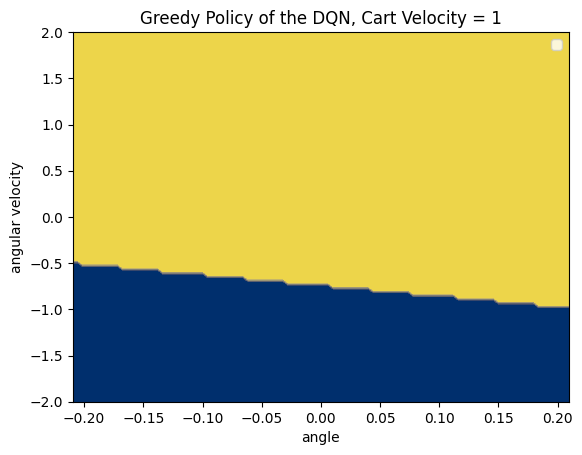

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


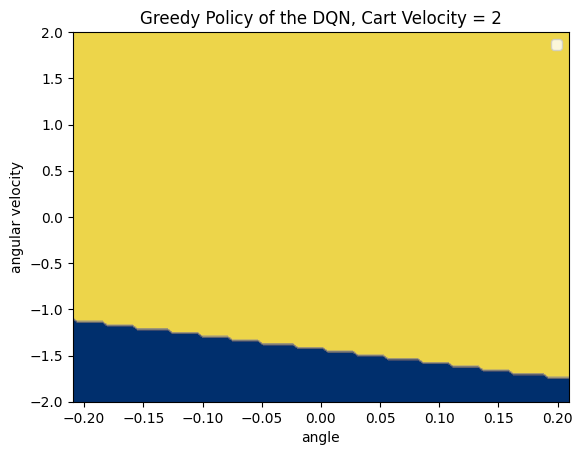

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


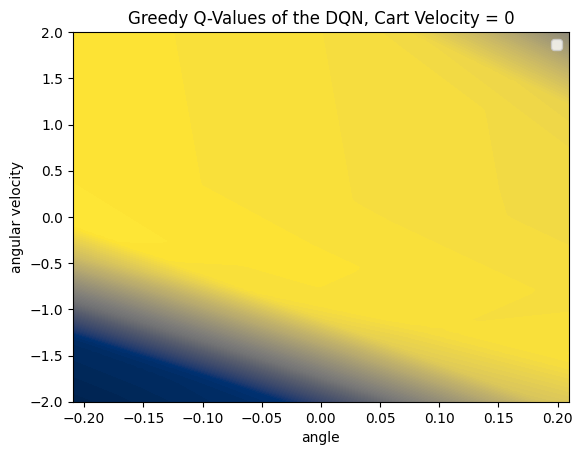

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


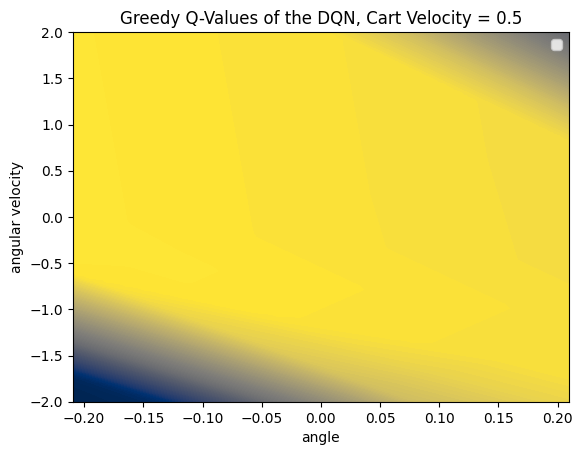

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


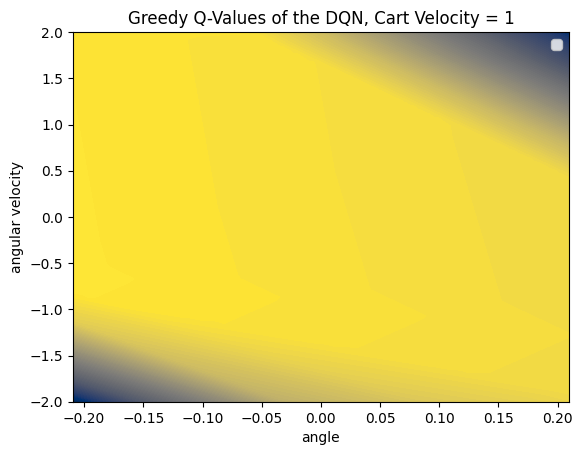

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


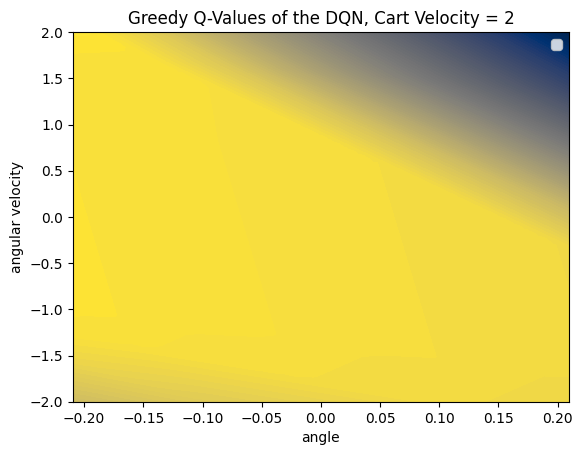

In [22]:
def visualise_policy(network):
    visualise_slice(network, cart_velocity=0, visualise_q=False)
    visualise_slice(network, cart_velocity=0.5, visualise_q=False)
    visualise_slice(network, cart_velocity=1, visualise_q=False)
    visualise_slice(network, cart_velocity=2, visualise_q=False)

def visulalise_q(network):
    visualise_slice(network, cart_velocity=0, visualise_q=True)
    visualise_slice(network, cart_velocity=0.5, visualise_q=True)
    visualise_slice(network, cart_velocity=1, visualise_q=True)
    visualise_slice(network, cart_velocity=2, visualise_q=True)

visualise_policy(dqn_net)
visulalise_q(dqn_net)

# Comparing to a DDQN

I wanted to try and make a DDQN to see what differences I can see. The following code does exactly that. All that changes is the loss function - the target network is now just used to identify the actions with the highest Q values, and the policy network evaluates the Q values of this action. There isn't that much difference - most likely due to the fact that the DDQN is not tuned - another grid search would have to take place with it.

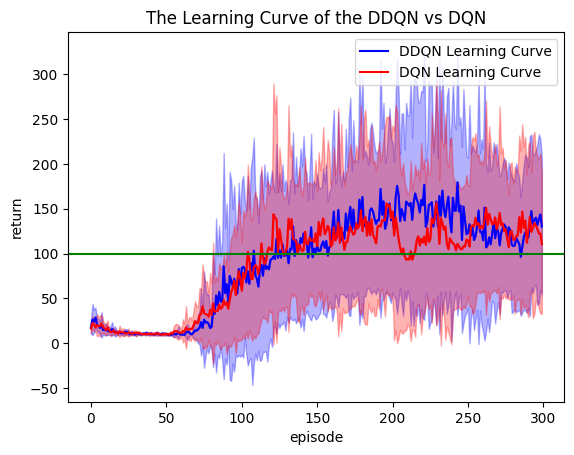

DQN(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [11]:
def compare_to_ddqn(dqn_means, dqn_stds, neurons_per_layer, epsilon_0, epsilon_decay_rate, learning_rate, replay_buffer_size, batch_size):
    """Create and plot a DDQN vs DQN."""
    no_episodes = 300
    runs_results_ddqn, trained_net_ddqn = run_experiment(neurons_per_layer=neurons_per_layer, epsilon_0=epsilon_0, epsilon_decay_rate=epsilon_decay_rate, learning_rate=learning_rate, num_runs=10, optimiser=optim.Adam, replay_buffer_size=replay_buffer_size, batch_size=batch_size, target_update_frequency=10, no_episodes=no_episodes, ddqn=True)
    results = torch.tensor(runs_results_ddqn)
    means = results.float().mean(0)
    stds = results.float().std(0)

    plt.plot(torch.arange(no_episodes), means, color='b', label = 'DDQN Learning Curve')
    plt.plot(torch.arange(no_episodes), dqn_means, color='r', label = 'DQN Learning Curve')
    plt.axhline(y=100, color='g', linestyle='-')
    plt.ylabel("return")
    plt.xlabel("episode")
    plt.fill_between(np.arange(no_episodes), means, means+stds, alpha=0.3, color='b')
    plt.fill_between(np.arange(no_episodes), means, means-stds, alpha=0.3, color='b')
    plt.fill_between(np.arange(no_episodes), dqn_means, dqn_means+dqn_stds, alpha=0.3, color='r')
    plt.fill_between(np.arange(no_episodes), dqn_means, dqn_means-dqn_stds, alpha=0.3, color='r')
    plt.legend()
    figname = 'The Learning Curve of the DDQN vs DQN'
    plt.title(figname)
    plt.show()
    return trained_net_ddqn

compare_to_ddqn(dqn_means=means, dqn_stds=stds, neurons_per_layer=neurons, epsilon_0=epsilon, epsilon_decay_rate=epsilon_decay, learning_rate=learning_rate, replay_buffer_size=replay_buff, batch_size=batch_size)